In [4]:
import pytest
import itertools
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

In [5]:
%load_ext cython

In [53]:
%%cython -f --compile-args=-fopenmp --link-args=-fopenmp --annotate
# cython: profile=True, cdivision=True, boundscheck=False, wraparound=False
import numpy as np
cimport numpy as np
from libc.stdlib cimport malloc, calloc, free
from libc.stdio cimport printf
from libc.math cimport sqrt
from cython.parallel cimport prange

DTYPE = np.float64 
ITYPE = np.intp

ctypedef np.npy_float64 DTYPE_t
ctypedef np.intp_t ITYPE_t

# Definition of a type for reduction function
# returning an integer
ctypedef ITYPE_t (*F_TYPE_t)(DTYPE_t*, ITYPE_t) nogil
DEF CHUNK_SIZE = 256
DEF N_THREADS = 4
DEF DEBUG = True

cdef inline DTYPE_t euclidean_dist(
    const DTYPE_t* x1,
    const DTYPE_t* x2,
    ITYPE_t size,
) nogil except -1:
    cdef DTYPE_t tmp, d=0
    cdef np.intp_t j
    for j in range(size):
        tmp = x1[j] - x2[j]
        d += tmp * tmp
    return sqrt(d)


cdef inline ITYPE_t argmin(
    DTYPE_t* dist,
    ITYPE_t length,
) nogil:
    cdef:
        ITYPE_t am = 0
        DTYPE_t dist_min = dist[0]
        ITYPE_t i
    
    for i in range(1, length):
        if dist[i] < dist_min:
            dist_min = dist[i]
            am = i
            
    return am

cdef inline ITYPE_t argmax(
    DTYPE_t* dist,
    ITYPE_t length,
) nogil:
    cdef:
        ITYPE_t am = 0
        DTYPE_t dist_max = dist[0]
        ITYPE_t i
    
    for i in range(1, length):
        if dist[i] > dist_max:
            dist_max = dist[i]
            am = i
            
    return am


cdef int _pairwise_distance_chunk(
    const DTYPE_t[:, ::1] X,        # IN
    const DTYPE_t[:, ::1] Y,        # IN
    ITYPE_t[::1] Z,                 # OUT  
    F_TYPE_t reduce_function,
) nogil except -1:
    cdef:
        ITYPE_t X_n = X.shape[0]
        ITYPE_t d   = X.shape[1]
        ITYPE_t Y_n = Y.shape[0]
        ITYPE_t Y_d = Y.shape[1]
        
        ITYPE_t i, j
        DTYPE_t* dist 
    
    # We store distance from vectors of Y to a given
    # vector of X here and store the reduction
    # result in Z
    dist = <DTYPE_t *> malloc(Y_n * sizeof(DTYPE_t)) 
    for i in range(X_n):
        for j in range(Y_n):
            dist[j] = euclidean_dist(&X[i,0], &Y[j,0], d)
        Z[i] = reduce_function(dist, Y_n)
    
    free(dist)
        
cdef int _pairwise_distance(
    const DTYPE_t[:, ::1] X,        # IN
    const DTYPE_t[:, ::1] Y,        # IN
    ITYPE_t[:, ::1] Z,              # OUT
    ITYPE_t chunk_size,
    F_TYPE_t reduce_function,
) nogil except -1:
    cdef:
        ITYPE_t n_samples_chunk = chunk_size / X.shape[1]
        
        ITYPE_t X_n_samples_chunk = min(X.shape[0], n_samples_chunk)
        ITYPE_t X_n_full_chunks = X.shape[0] // X_n_samples_chunk
        ITYPE_t X_n_samples_rem = X.shape[0] % X_n_samples_chunk

        ITYPE_t Y_n_samples_chunk = min(Y.shape[0], n_samples_chunk)
        ITYPE_t Y_n_full_chunks = Y.shape[0] / Y_n_samples_chunk
        ITYPE_t Y_n_samples_rem = Y.shape[0] % Y_n_samples_chunk
        
        # count remainder chunk in total number of chunks
        ITYPE_t X_n_chunks = X_n_full_chunks + (X.shape[0] != (X_n_full_chunks * X_n_samples_chunk))
        ITYPE_t Y_n_chunks = Y_n_full_chunks + (Y.shape[0] != (Y_n_full_chunks * Y_n_samples_chunk))
        
        ITYPE_t n_chunks = X_n_chunks * Y_n_chunks
        ITYPE_t num_threads = max(n_chunks, N_THREADS)

        
        ITYPE_t idx
        ITYPE_t i_chunk = 0
        
        ITYPE_t X_start, X_end, Y_start, Y_end
        ITYPE_t X_chunk_idx, Y_chunk_idx

    if DEBUG:
        printf("Using %d chunk pairs", n_chunks)
    
    # for X_chunk_idx in prange(X_n_chunks, schedule='static', num_threads=num_threads):
    for X_chunk_idx in range(X_n_chunks):
        X_start = X_chunk_idx * X_n_samples_chunk
        if X_chunk_idx == X_n_chunks - 1 and X_n_samples_rem > 0:
            X_end = X_start + X_n_samples_rem
        else:
            X_end = X_start + X_n_samples_chunk
            
        for Y_chunk_idx in range(Y_n_chunks):
            Y_start = Y_chunk_idx * Y_n_samples_chunk
            if Y_chunk_idx == Y_n_chunks - 1 and Y_n_samples_rem > 0:
                Y_end = Y_start + Y_n_samples_rem
            else:
                Y_end = Y_start + Y_n_samples_chunk

            if DEBUG:
                printf("Chunk pair\n")
                printf("X[%d:%d, :]\n", X_start, X_end)
                printf("Y[%d:%d, :]\n", Y_start, Y_end)
                printf("\n")
                        
            _pairwise_distance_chunk(X[X_start:X_end, :],
                                     Y[Y_start:Y_end, :],
                                     Z[Y_chunk_idx, X_start:X_end],
                                     reduce_function)
    
            # We need to add an offset here on indices here
            for idx in range(X_start, X_end):
                Z[Y_chunk_idx, idx] += Y_start

    if DEBUG:
        printf("Done cdef\n\n")

# Python-accessibles interfaces
            
cpdef np.ndarray[ITYPE_t, ndim=1, mode='c'] pairwise_distance_chunk(
    np.ndarray[DTYPE_t, ndim=2, mode='c'] X,
    np.ndarray[DTYPE_t, ndim=2, mode='c'] Y,
    reduction = 'argmin',
):
    cdef:
        ITYPE_t[::1] Z = np.zeros((X.shape[0],), dtype=ITYPE)
    
    if reduction == 'argmin':
        _pairwise_distance_chunk(X, Y, Z, &argmin)
    elif reduction == 'argmax':
        _pairwise_distance_chunk(X, Y, Z, &argmax)    
    else:
        raise ValueError(f"Reduction {reduction} is unknown.")
    return np.asarray(Z)


        
cpdef np.ndarray[ITYPE_t, ndim=2, mode='c'] pairwise_distance(
    np.ndarray[DTYPE_t, ndim=2, mode='c'] X,
    np.ndarray[DTYPE_t, ndim=2, mode='c'] Y,
    reduction = 'argmin',
    int chunk_size = CHUNK_SIZE,
):
    # We duplicate code here to compute the shape of Z which we need
    # TODO: find a way to remove it
    cdef:
        ITYPE_t n_samples_chunk = chunk_size / X.shape[1]
        ITYPE_t Y_n_samples_chunk = min(Y.shape[0], n_samples_chunk)
        ITYPE_t Y_n_chunks = Y.shape[0] / Y_n_samples_chunk
        ITYPE_t n_chunks_Y = Y_n_chunks + (Y.shape[0] != (Y_n_chunks * Y_n_samples_chunk))
        
        ITYPE_t[:, ::1] Z = np.zeros((n_chunks_Y, X.shape[0]), dtype=ITYPE)
    
    if reduction == 'argmin':
        _pairwise_distance(X, Y, Z, chunk_size, &argmin)
    elif reduction == 'argmax':
        _pairwise_distance(X, Y, Z, chunk_size, &argmax)    
    else:
        raise ValueError(f"Reduction {reduction} is unknown.")
    return np.asarray(Z)

In [54]:
X_chunk = np.random.rand(50).reshape((-1, 2))
Y_chunk = np.copy(X_chunk[::2]) + 0.02
X_chunk.shape, Y_chunk.shape

((25, 2), (13, 2))

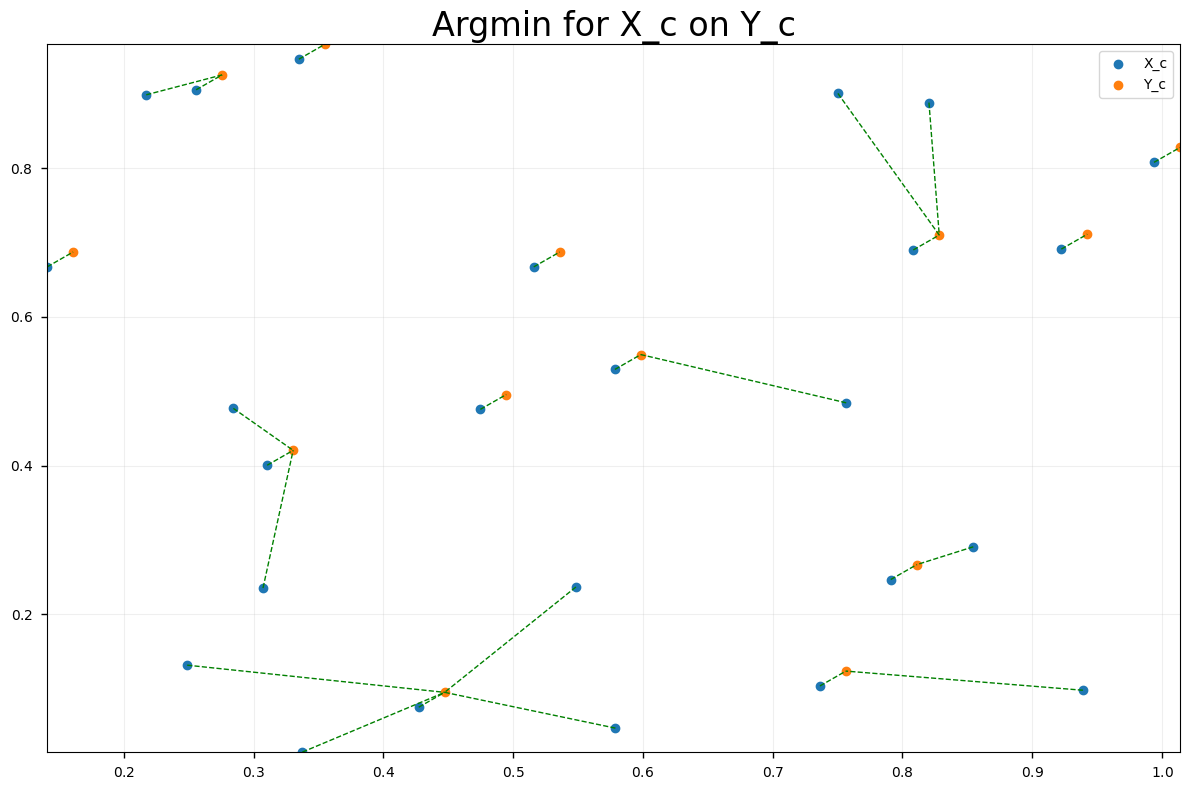

In [55]:
argmins = pairwise_distance_chunk(X_chunk, Y_chunk)

plt.scatter(X_chunk[:,0], X_chunk[:,1])
plt.scatter(Y_chunk[:,0], Y_chunk[:,1])
plt.legend(["X_c","Y_c"])

for i, j in enumerate(argmins):
    plt.plot((X_chunk[i, 0], Y_chunk[j, 0]),
             (X_chunk[i, 1], Y_chunk[j, 1]),
             'g--', linewidth=1);
    
plt.title("Argmin for X_c on Y_c")

plt.show();

In [25]:
def create_dummy(dtype, working_memory, d=2):
    f_size = {
        np.float64: 8,
        np.float32: 4,
    }[dtype]
    
    i_size = 8
        
    n = working_memory // (2 * d * f_size + i_size)
    
    X = np.random.randn(n, d).astype(dtype)
    Y = X + 0.05
    return X, Y

In [26]:
@pytest.mark.parametrise("dtype", [np.float64])
@pytest.mark.parametrise("working_memory", [2 ** i for i in range(5, 12)])
@pytest.mark.parametrise("d", [2, 5, 10, 100])
def test_pairwise_chunk_on_dummy(dtype, working_memory, d):
    
    X_chunk, Y_chunk = create_dummy(dtype, working_memory=working_memory, d=d)
    
    Z_chunk = pairwise_distance_chunk(X_chunk, Y_chunk)
    
    memory = (X_chunk.nbytes + Y_chunk.nbytes + Z_chunk.nbytes)
    assert memory <= working_memory, (memory, working_memory)

In [27]:
for dtype, working_memory, d in itertools.product([np.float64],
                                              [2 ** i for i in range(5, 12)],
                                              [2, 5, 10, 100]):
    test_pairwise_chunk_on_dummy(dtype, working_memory, d)

In [62]:
X = np.random.randn(2 ** 10).reshape((-1, 2))
Y = np.copy(X) + 1

In [63]:
X.nbytes / 1e9, Y.nbytes /1e9

(8.192e-06, 8.192e-06)

In [64]:
X.shape, Y.shape

((512, 2), (512, 2))

In [66]:
argmins_on_chunks = pairwise_distance(X,Y)

In [67]:
argmins_on_chunks.shape

(4, 512)

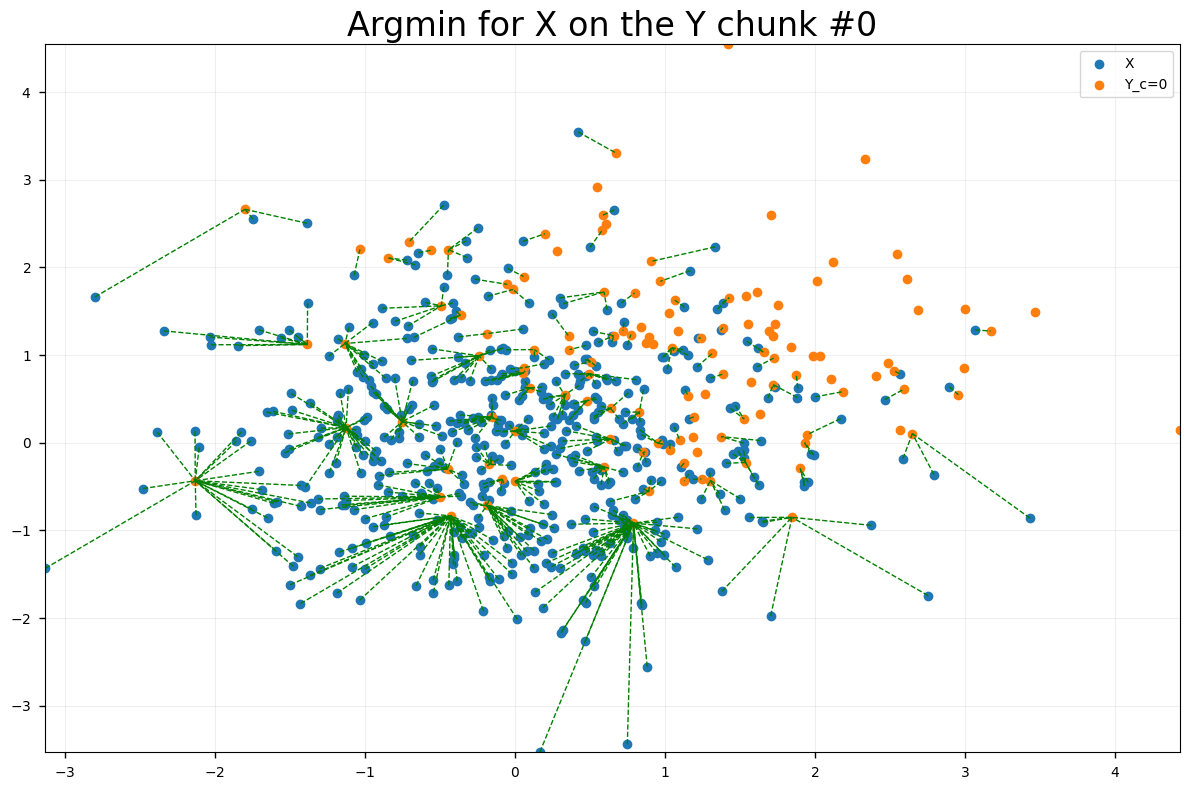

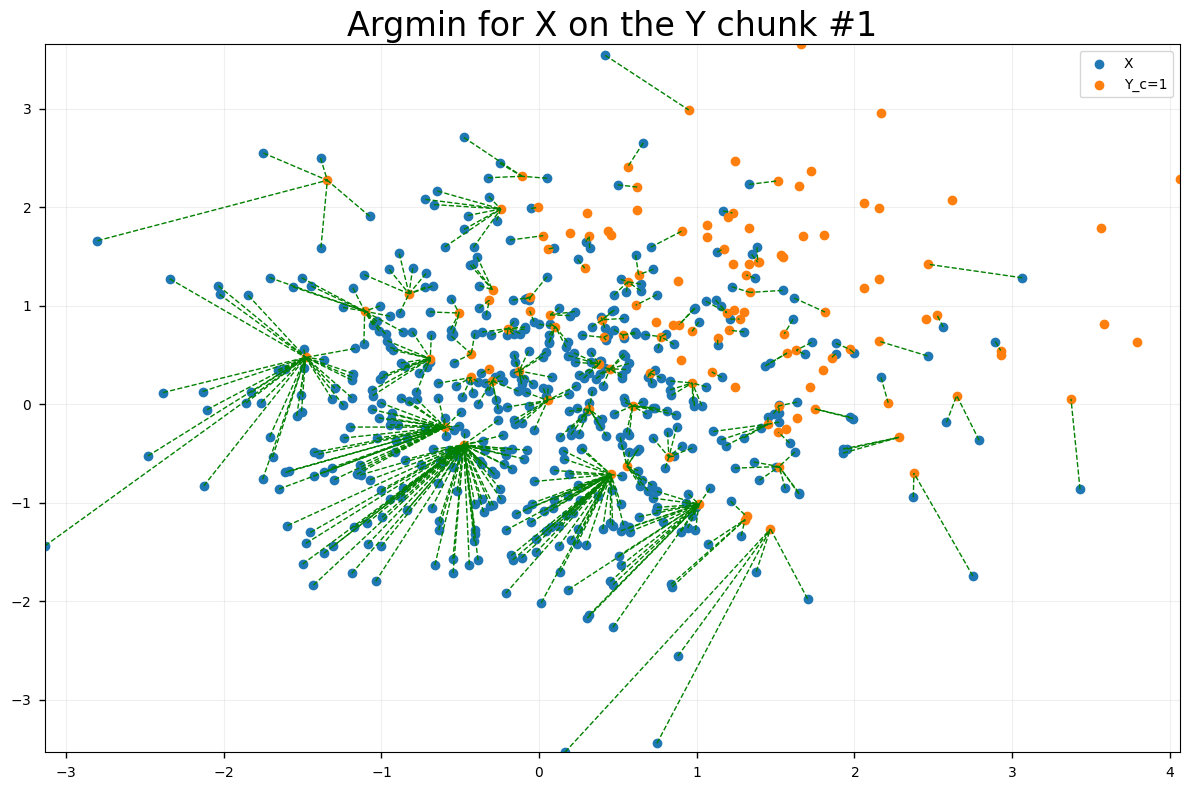

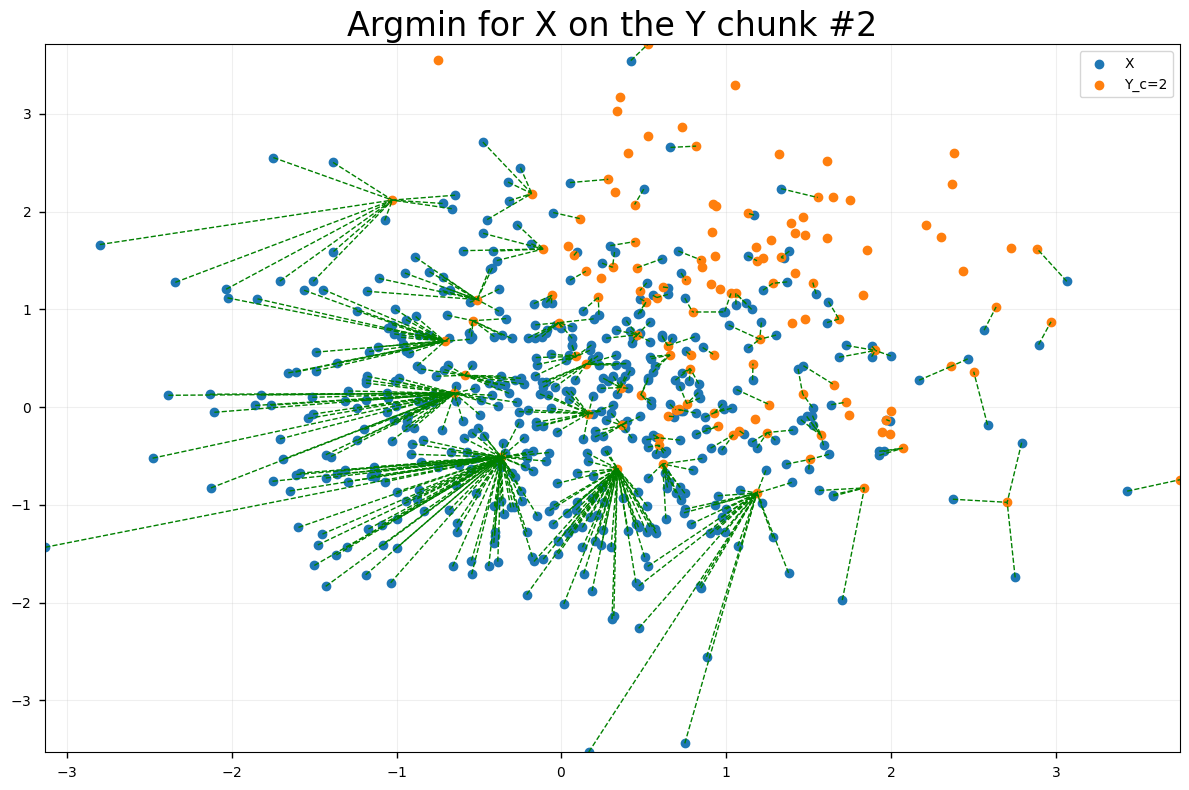

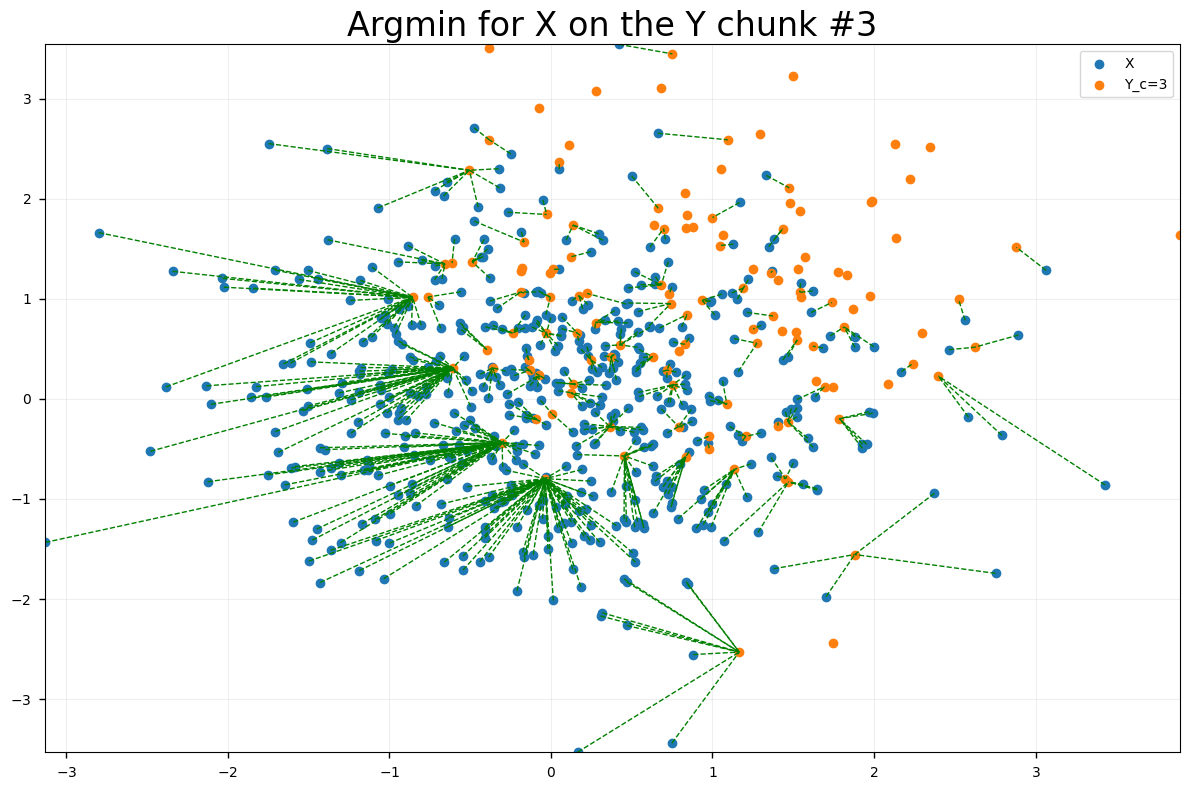

In [68]:
Y_chunk_n_samples = Y.shape[0] // argmins_on_chunks.shape[0]
for c, argmins_chunk in enumerate(argmins_on_chunks):
    Y_c = Y[c*Y_chunk_n_samples:(c+1)*Y_chunk_n_samples,:]
    
    _ = plt.scatter(X[:,0], X[:,1]);
    _ = plt.scatter(Y_c[:,0], Y_c[:,1]);
    _ = plt.legend(["X", f"Y_c={c}"]);
    
    for i, j in enumerate(argmins_chunk):
         _ = plt.plot((X[i, 0], Y[j, 0]),
                 (X[i, 1], Y[j, 1]),
                 'g--', linewidth=1);
    
    _ = plt.title(f"Argmin for X on the Y chunk #{c}");

    plt.show()

In [35]:
X.nbytes

4096